In [19]:
import re
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.corpus import stopwords
import pymorphy2

from itertools import chain
from collections import Counter

import matplotlib.pyplot as plt

from config import train_path, test_path

In [2]:
df_train = pd.read_csv(train_path, index_col=0)

In [3]:
sentences = df_train['sentence'].values.tolist()
labels = df_train['label'].values.tolist()

del df_train

In [4]:
data = [re.sub('\S*@\S*\s?', '', sent) for sent in sentences]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [6]:
data_words = list(sent_to_words(data))

In [7]:
data_words = [[word for word in words if len(word) >= 3] for words in data_words]

In [8]:
stop_words = stopwords.words('russian')

In [9]:
morph = pymorphy2.MorphAnalyzer()

In [10]:
data_words = [[morph.parse(word)[0].normal_form for word in words] for words in data_words]

In [11]:
data_words = [[word for word in words if word not in stop_words] for words in data_words]

In [12]:
data_words = [[word for word in words if len(word) >= 3] for words in data_words]

In [14]:
words = list(chain(*data_words))

In [16]:
len(set(words))

4466

In [18]:
words_count = Counter(words)

(array([9120., 3561., 2034., 1415., 1269.,  971.,  774.,  675.,  600.,
         502.]),
 array([   0. ,  446.5,  893. , 1339.5, 1786. , 2232.5, 2679. , 3125.5,
        3572. , 4018.5, 4465. ]),
 <BarContainer object of 10 artists>)

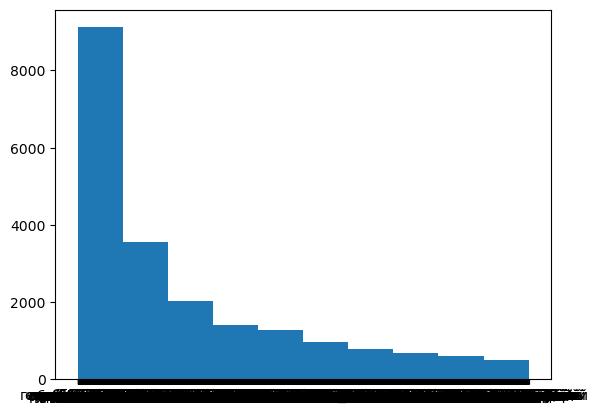

In [22]:
plt.hist(words)

In [24]:
data_words_w = [[word for word in words if words_count[word] > 5] for words in data_words]

In [28]:
words = list(chain(*data_words_w))

dictionary = list(set(words))

In [29]:
len(dictionary)

695

In [31]:
id2word = corpora.Dictionary(data_words_w)
corpus = [id2word.doc2bow(text) for text in data_words_w]

In [106]:
models = []
label_counts = []
metrics = []

for k in range(2, 30):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=k,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=100,
                                                alpha='auto',
                                                per_word_topics=True)

    labels_count_pred = {i: 0 for i in range(k)}


    for data, label in zip(corpus, labels):
        if label == 1:
            pred = lda_model[data][0]
            label_pred, value = sorted(pred, key=lambda x: -x[1])[0]

            labels_count_pred[label_pred] += 1

    vals = labels_count_pred.values()
    metric = sum([abs(0.5 - val / sum(vals)) for val in vals]) / len(vals)

    print(f'k: {k}, v: {round(metric, 4)}')

    models.append(lda_model)
    label_counts.append(labels_count_pred)
    metrics.append(metric)

k: 2, v: 0.3328
k: 3, v: 0.2913
k: 4, v: 0.3845
k: 5, v: 0.3
k: 6, v: 0.3333
k: 7, v: 0.3571
k: 8, v: 0.4726
k: 9, v: 0.3889
k: 10, v: 0.4
k: 11, v: 0.4091
k: 12, v: 0.464
k: 13, v: 0.4766
k: 14, v: 0.4713
k: 15, v: 0.4745
k: 16, v: 0.4375
k: 17, v: 0.4692
k: 18, v: 0.4875
k: 19, v: 0.4474
k: 20, v: 0.45
k: 21, v: 0.4524
k: 22, v: 0.4545
k: 23, v: 0.4565
k: 24, v: 0.4633
k: 25, v: 0.46
k: 26, v: 0.4615
k: 27, v: 0.463
k: 28, v: 0.4648
k: 29, v: 0.4655


In [108]:
metrics[6]

0.472644376899696

In [109]:
label_counts[6]

{0: 293, 1: 16, 2: 2, 3: 1, 4: 3, 5: 8, 6: 1, 7: 5}

In [113]:
detection_accuracy = label_counts[6][0] / sum(label_counts[6].values())
detection_accuracy

0.8905775075987842

In [110]:
metrics[16]

0.4875042215467748

In [111]:
label_counts[16]

{0: 7,
 1: 0,
 2: 8,
 3: 0,
 4: 3,
 5: 2,
 6: 1,
 7: 4,
 8: 0,
 9: 1,
 10: 0,
 11: 2,
 12: 292,
 13: 2,
 14: 1,
 15: 2,
 16: 3,
 17: 1}

In [114]:
detection_accuracy = label_counts[16][12] / sum(label_counts[16].values())
detection_accuracy

0.8875379939209727

In [146]:
lda_model = models[16]  # models[6]
k = 18  # 8
detect_topic = 12  # 0

In [129]:
df_test = pd.read_csv(test_path, index_col=0)

In [130]:
data = df_test['text'].values.tolist()

In [128]:
from tqdm.auto import tqdm

data_ = []
for sent in tqdm(data):
    try:
        tmp = re.sub('\S*@\S*\s?', '', sent)
    except:
        tmp = ""
    data_.append(tmp)
# [re.sub('\S*@\S*\s?', '', sent) for sent in data]

data = [re.sub('\s+', ' ', sent) for sent in data_]
data = [re.sub("\'", "", sent) for sent in data]

data_words = list(sent_to_words(data))
data_words = [[morph.parse(word)[0].normal_form for word in words] for words in tqdm(data_words)]

  0%|          | 0/10571 [00:00<?, ?it/s]

  0%|          | 0/10571 [00:00<?, ?it/s]

In [131]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [152]:
preds = []
values = []

for data in corpus:
    pred = lda_model[data][0]
    label_pred, value = sorted(pred, key=lambda x: -x[1])[0]

    label_pred = 1 if label_pred == detect_topic and value >= 0.3 else 0
    preds.append(label_pred)
    values.append(value)

df_test['label'] = pd.Series(preds, index=df_test.index)

In [153]:
df_test.to_csv('res/lda_pred.csv', encoding='utf-8', sep=';')

In [157]:
lda_model.save('res/lda_model/lda.model')